# BioNeMo - MegaMolBART Inferencing for Generative Chemistry

This tutorial showcases how to run a container for with a pre-trained MegaMolBART model, and using it for inferencing and generative chemistry related tasks. At the end of this tutorial, a user will learn

- launching the BioNeMo container for MegaMolBART inferencing
- various functionalities provided in BioNeMo for obtaining chemical embeddings
- use the learned representations for generative AI and downstream predictive modeling tasks


<a id='contents'></a>
## Setting up MegaMolBART 



### Prerequisites:
- BioNeMo Framework container is running (refer to the [Quickstart Guide](../quickstart-fw.md))
- Familiarity with some components of the BioNeMo framework such as the [Models](../models/megamolbart.md) and [Inferencing](../inference-grpc-fw.md)


#### Downloading pre-trained models


This example requires a MegaMolBART pre-trained model, which the user can download and mount the directory containing the model while launching the container, as described below. 

The basic building blocks are already implemented in the BioNeMo Framework. It comes with a set of scripts that make it easier to download pre-trained models from NVIDIA NGC. As of the pre-release version (13 JUN 2023), we have the following models available.
    - Molecule/MegaMolBART
    - Protein/ESM-1nv
    - Protein/ProtT5nv

Once the container has been successfully pulled and the `.env` file configured correctly, download the pre-trained models with __`bash launch.sh download`__ in the BioNeMo directory

For example, we can see MegaMolBart being download from __`https://api.ngc.nvidia.com/v2/models/nvidia/clara/megamolbart_0_2/versions/0.2.0/zip`__

Once execution is complete, you will see files with the `.nemo` extension within the folder specified in the `MODEL_PATH=${MODEL_PATH:=${PROJECT_PATH}/<DIRECTORY>}` configuration of your `.env` file.

#### Running the BioNeMo container

This example has been built by launching the container in a local machine with 2 x A6000 RTX GPUs. Refer to specific instructions for [remote and multi-node launch]

__`docker run -it -p 8888:8888 --gpus all -v <model_directory>:</model> <BioNeMo_Image_Link> <model>`__

We ran the following command to initiate the container to run MegaMolBART model on BioNeMo:

In the command below, update the `{deploy_ngc_registry}` with the correct BioNeMo NGC container link. 

__`docker run -it -p 8888:8888 --gpus all -v ~/path/to/downloaded/model:/model {{deploy_ngc_registry}} megamolbart`__


Once the container is launched, navigate to http://0.0.0.0:8888, http://localhost:8888, or the IP address of the workstation/node. A JupyterLab instance should show up.


#### Copy this code and input files into JupyterLab

In the launched JupyterLab, run the codes in a Jupyter notebook as provided in the code cells below, and copy the [`benchmark_MoleculeNet_ESOL.csv`](./benchmark_MoleculeNet_ESOL.csv) to the Jupyter-Lab working directory.

***
<a id='contents'></a>
## Overview


This walk-through will cover the following aspects of BioNeMo-MegaMolBART. For more details, visit the [BioNeMo-MegaMolBART on NVIDIA Clara Discovery](https://www.nvidia.com/en-us/clara/drug-discovery/).

<a href='#section1'> **BioNeMo-MegaMolBART Inference Functions**</a>: 

- In this section, we will explore the key inference functionalities of the pre-trained model accessible through the __`InferenceWrapper`__. 

It includes functions to obtain latent space representations  __`smis_to_hidden`__, embeddings __`smis_to_embedding`__ using input SMILES, as well as obtaining SMILES from latent space representations __`hidden_to_smis`__.
<br><br><br>

<a href='#section2'> **Molecule Generation / Chemical Space Exploration**</a>:

- Here, we will explore the chemical space around input query compound, and generate related compounds.

<br><br>
![mmb_1](../images/MMB_molecule_generation_1.png)
<br><br><br>


<a href='#section3'> **Using Embeddings for Predictive Modeling**</a>:  

- Finally, we will use the embeddings obtained from the BioNeMo-MegaMolBART for a chemical dataset and use these embeddings as features to create a machine learning model to predict properties of the compounds. To evaluate the quality of these embeddings, we will also obtain Morgan Fingerprints to create a comparable prediction model.

<br><br><br>
![mmb_1](../images/MMB_molecule_generation_2.png)
<br><br><br>


***


:::{note}
The following cells containing python code snippets can be directly copied and executed into a Python environment such as a Jupyter notebook running in a BioNemo container.
:::


_**Importing required libraries**_

In the following cell, we are importing the libraries required for running the intended tasks for this tutorial. 

It includes open-source CUDA accelarated data science and machiene learning libraries such as cuML, cuDF, cuPY. For more information, check out [NVIDIA RAPIDS](https://rapids.ai/). 

[cuDF](https://github.com/rapidsai/cudf) provides a pandas-like API that will be familiar to data engineers & data scientists, so they can use it to easily accelerate their workflows without going into the details of CUDA programming. Similarly, [cuML](https://github.com/rapidsai/cuml) enables data scientists, researchers, and software engineers to run traditional tabular ML tasks on GPUs. In most cases, cuML's Python API matches the API from scikit-learn.

Additionally, we will be using RD-Kit package, which is an open-source cheminformatics package (https://www.rdkit.org/).

In [1]:
# Importing required libraries from RAPIDS, Pandas and NumPy packages
from infer import InferenceWrapper
import cuml
import cudf
import cupy as cp
from cuml import LinearRegression
from cuml.svm import SVR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import logging
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Importing libraries from RD-Kit for handling and manipulating chemical data
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
IPythonConsole.molSize=250,250

<a id='section1'></a>

## BioNeMo-MegaMolBART Inference Functions:

### Setup the connection to the inference wrapper and providing example compounds

In this cell, we are making a connection to the __`InferenceWrapper`__ and accessing the inferencing functions in the following cell. 

__`InferenceWrapper`__ is an adaptor that allows interaction with the inference service of BioNeMo_MegaMolBART pre-trained model.

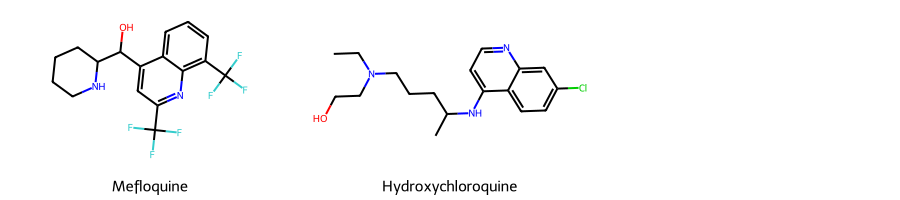

In [2]:
# Making a connection to the InferenceWrapper 
connection = InferenceWrapper()

# Here, we are taking two example SMILES for two widely used Antimalarial drugs -- Mefloquine and Hydroxychloroquine
smis = ['OC(c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)C1CCCCN1',     
        'CCN(CCO)CCCC(C)Nc1ccnc2cc(Cl)ccc12'] 

# Let us draw these two drugs and see how their 2-D structure looks like, using RD-Kit's functionalities
m1 = Chem.MolFromSmiles(smis[0])
m2 = Chem.MolFromSmiles(smis[1])
Draw.MolsToGridImage((m1,m2), legends=["Mefloquine","Hydroxychloroquine"], subImgSize=(300,200))

### Going from SMILES to hidden state

The __`smis_to_hidden`__ functionality, accessible through the __`InferenceWrapper`__, queries the model to fetch the latent space representation of the SMILES.
<br> <br>  A high level conceptual depiction below shows the process of obtaining the hidden states. <br><br>
![mmb_3](../images/MMB_molecule_generation_3.png)

Now that we looked at how the two example drug structures look in 2D, let's use the pre-trained BioNeMo-MegaMolBART model to obtain their hidden state representations.

In [ ]:
# obraining the hidden state representations for input SMILES
hidden_states, pad_masks = connection.smis_to_hidden(smis)

 and let's look at the shape of the hidden state representations

In [4]:
hidden_states.shape, pad_masks.shape

(torch.Size([2, 46, 512]), torch.Size([2, 46]))

### SMILES to Embedding

Here, the __`smis_to_embedding`__ function queries the model to fetch the encoder embedding for the input SMILES.

![mmb_4](../images/MMB_molecule_generation_4.png)

In [5]:
# Similarly, let's obtain the learned embeddings for these two compounds.
embedding = connection.smis_to_embedding(smis)

<br>

Let's check the shapes of obtained embeddings

In [6]:
embedding.shape

torch.Size([2, 512])

<br> Looking at the shape of the embeddings, do you recognize the difference between embeddings and the hidden state dimensions? 
<br><br>Why is this difference?

### Hidden state to SMILES

In order to obtain SMILES from the latent space chemical representation, the __`hidden_to_smis`__ is used for decoding the latent space representation (here, _hidden state_) back to SMILES.
<br>


![mmb_5](../images/MMB_molecule_generation_5.png)


In this cell, we will obtain SMILES chemical representation from a hidden state for the two example compounds. 


In [7]:
# Obtaining SMILES chemical representation from a hidden state using the hidden_to_smis function 
inferred_smis = connection.hidden_to_smis(hidden_states, pad_masks)

# let's look at the inferred SMILES
inferred_smis

['c1ccc2c(C(C3CCCCN3)O)cc(C(F)(F)F)nc2c1C(F)(F)F', 'C(CCC(C)Nc1ccnc2cc(Cl)ccc21)N(CC)CCO']

<br>
Let's visualize these two inferred SMILES using RD-Kit functionalities

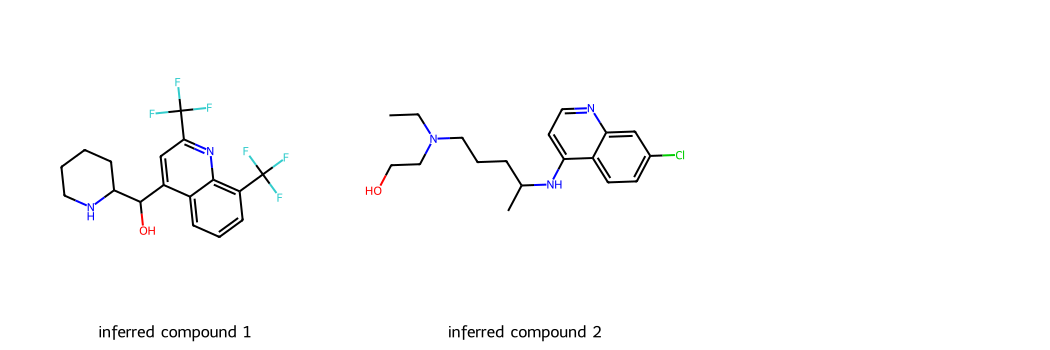

In [8]:
# First converting inferred SMILES to Mol object using RD-Kit
inf_1 = Chem.MolFromSmiles(inferred_smis[0])
inf_2 = Chem.MolFromSmiles(inferred_smis[1])

# ...followed by drawing them as 2-D structures
Draw.MolsToGridImage((inf_1,inf_2),legends=["inferred compound 1","inferred compound 2"], subImgSize=(350,350))

<br><br><br>
Comparing these inferred compounds to the original input - they are the same compounds! In the next section, you will learn how to generate different compounds from the input.
<br><br>
__This concludes the first objective of evaluating the inference functionalities of BioNeMo_MegaMolBART.__

<a href='#contents'> __[Go to the top]__</a>

<a id='section2'></a>

## Molecule Generation / Chemical Space Exploration

In this section, we will use the pre-trained BioNeMo-MegaMolBART model for generating designs of novel small-molecules which are analogous to the query compound(s). 

First, we will obtain the hidden state representation for the query compounds using the __`smis_to_hidden`__ functionality (as also described in the previous section).

Once the hidden state(s) are obtained, we will use the function __`chem_sample`__, as defined below, to manipulate the hidden states, followed by decoding those to generate new chemical designs.

<br><br>
![mmb_1](../images/MMB_molecule_generation_1.png)
<br><br><br>


### First, let's define `chem_sample` --- the generation function


The function takes query SMILES as an input, and returns valid and unique set of generated SMILES.

__`chem_sample`__ function has two main components.

1. Obtaining the hidden state representation for the input SMILES, followed by perturbing the copies of hidden states, and decoding those perturbed hidden states to obtain new SMILES.
2. Using the RD-Kit functionalities, check the uniqueness of the generated SMILES set, and retain those that are valid expressions.

In [9]:
# Importing PyTorch library (for more details: https://pytorch.org/)
import torch

# Defining the chemical sampling/generation function
def chem_sample(smis):
    
    num_samples = 20       # Maximum number of generated molecules per query compound
    scaled_radius = 0.7    # Radius of exploration [range: 0.0 - 1.0] --- the extent of perturbation of the original hidden state for sampling
    hidden_states, enc_masks = connection.smis_to_hidden(smis)    # Obtaining the hidden state representation(s) for input SMILES
    sample_masks = enc_masks.repeat_interleave(num_samples, 0)    # This and following lines are perturbing the hidden state to obtain analogous compounds
    perturbed_hiddens = hidden_states.repeat_interleave(num_samples, 0)
    perturbed_hiddens = perturbed_hiddens + (scaled_radius * torch.randn(perturbed_hiddens.shape).to(perturbed_hiddens.device))
    samples = connection.hidden_to_smis(perturbed_hiddens, sample_masks)
    
    # In this code block, we are doing some checks for the validity of the generated SMILES and for de-duplication of the set,
    #    returning only valid and unique SMILES
    samples = set(samples)
    valid_molecules = []
    for smi in set(samples):
        isvalid = False
        mol = Chem.MolFromSmiles(smi)
        if mol:
            isvalid = True
            valid_molecules.append(smi)
    uniq_canonical_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(smi),True) for smi in valid_molecules]
    
    return uniq_canonical_smiles

### Generating analogous small molecules and visualizing them


In this step, we will use the same two example drug molecules -- Mefloquine and Hydroxychloroquine -- for generating new analogues. 

In [10]:
# The example SMILES for two widely used Antimalarial drugs -- Mefloquine and Hydroxychloroquine
smis = ['OC(c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)C1CCCCN1',     
        'CCN(CCO)CCCC(C)Nc1ccnc2cc(Cl)ccc12'] 

# Using the chem_sample function and providing smis as input
gen_smis = chem_sample(smis)

<br> Now, let's take a look at the generated designs. 

You will recognize some of the generated designs analogous to the first query (Mefloquine), whereas others would be more similar to the second query (Hydroxychloroquine).

Total unique molecule designs obtained:  17


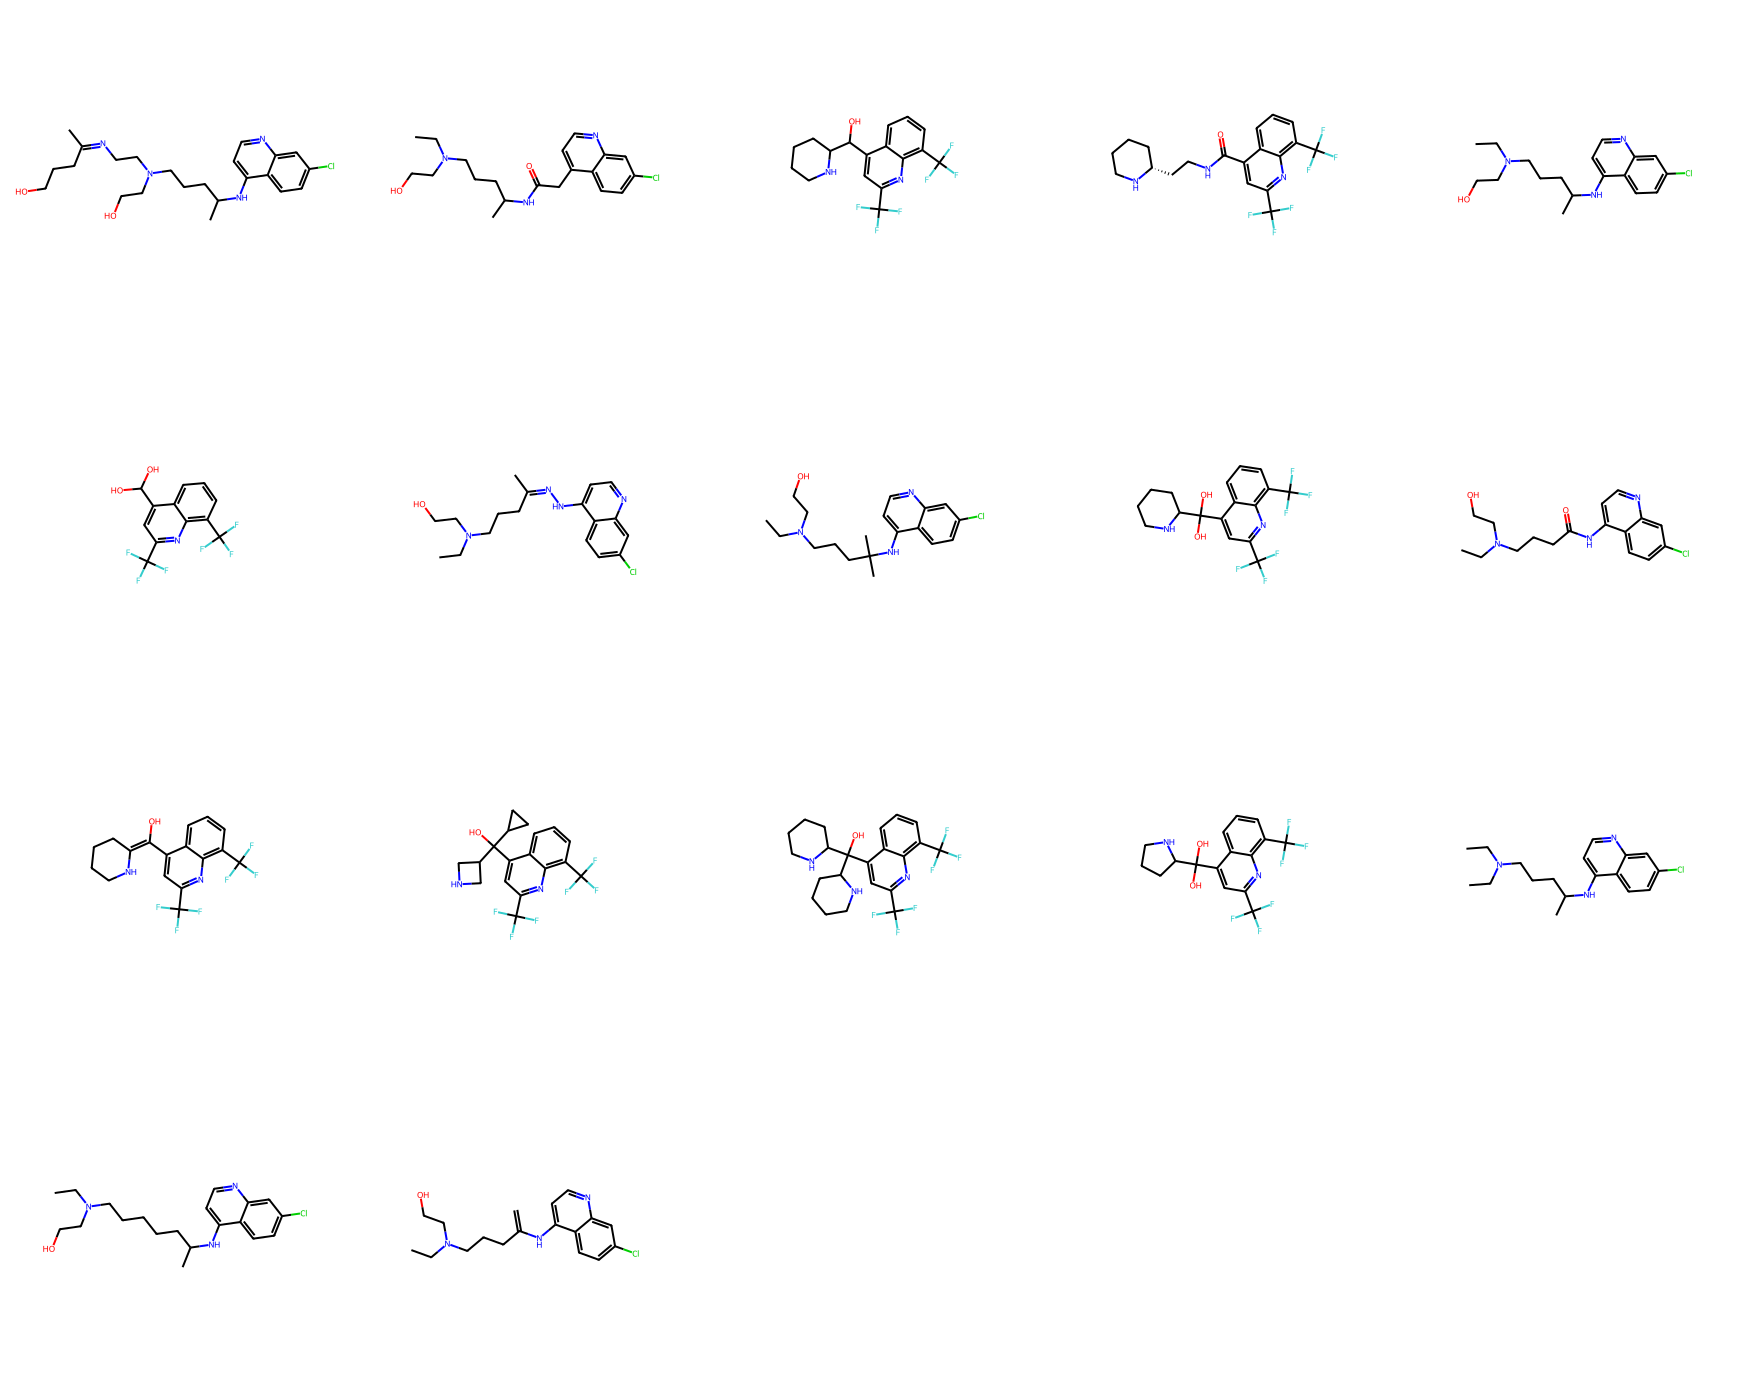

In [11]:
mols_from_gen_smis = [Chem.MolFromSmiles(smi) for smi in set(gen_smis)]
print("Total unique molecule designs obtained: ", len(mols_from_gen_smis))
Draw.MolsToGridImage(mols_from_gen_smis, molsPerRow=5, subImgSize=(350,350))

<br><br><br>

How many molecular designs were obtained from this step? 

What would change in the process if you try different values for _number of samples_ and _sampling radious_ in the __`chem_sample`__ function? 


__This concludes the Second objective of using the BioNeMo-MegaMolBART pre-trained model for chemical space exploration and generative chemistry.__


<a href='#contents'> __[Go to the top]__</a>

***

<a id='section3'></a>

## Downstream Prediction Model using Learned Embeddings from Pre-trained Model 

One of the improtant tasks for chemoinformaticians is to develop models for predicting properties of small molecules. 

These properties may include physicochemical parameters, such as lipophilicity, solubility, hydration free energy (LogP, LogD, and so on). It can also include certain pharmacokinetic/dynamic behaviors such as Blood-Brain-Barrier/CNS permeability, Vd, and so on. 

Modeling such properties can often become challenging along with choosing the appropriate and relevant descriptors/features for developing such prediction models.

In this section, we will use the embeddings as a feature set for training a machine learning model for physico-chemical parameter predictions. Then, we will compare how this model performs compared to a model developed using chemical fingerprints (here, _Morgan Fingerprints_). 


In the section below, we will be using the one of the following datasets curated by MoleculeNet -- ESOL dataset (https://moleculenet.org/datasets-1)

* **Lipophilicity**: Experimental results of octanol/water distribution coefficient(logD at pH 7.4) [n=4200]
* **FreeSolv**: Experimental and calculated hydration free energy of small molecules in water [n=642]
* **ESOL**: Water solubility data(log solubility in mols per litre) for common organic small molecules [n=1129]

<br><br>
![mmb_2](../images/MMB_molecule_generation_2.png)
<br><br><br>



### Example: Compound Water Solubility (ESOL) Prediction

In this example, we will use the __ESOL__ dataset from Moleculenet. The dataset is modified for this example purposes to include the relevant columns and placed in __`/data`__ directory as __`benchmark_MoleculeNet_ESOL.csv`__.

We will load the data from `benchmark_MoleculeNet_ESOL.csv` file in a _cuDF_ dataframe format. After that, we will obtain the embeddings for compounds that are present in the [cuDF](https://github.com/rapidsai/cudf) dataframe by using previously introduced __`smis_to_embedding`__ functionality of the BioNeMo-MegaMolBART pre-trained model.

Similarly, we will obtain _Morgan Fingerprints_ for the compounds in the dataframe using RD-Kit's __`AllChem.GetMorganFingerprintAsBitVect()`__ functionality.

Finally, we will generate two _Support Vector Rgression_ model -- using the embeddings and the _Morgan Fingerprints_ -- with functionalities from [cuML](https://github.com/rapidsai/cuml) library. At the end, we will compare the performances of both the models. 


###  Preprocessing dataset using cuDF

In [12]:
# Reading the benchmark_MoleculeNet_ESOL.csv file as cuDF DataFrame format
ex_data_file = './benchmark_MoleculeNet_ESOL.csv'
ex_df = cudf.read_csv(ex_data_file)

# Checking the dimensions of the dataframe and the first few rows
print(ex_df.shape)
ex_df.head()

(1128, 4)


index  task                              SMILES  \
0      0  ESOL                       Cc1cccc(C)c1O   
1      1  ESOL                      ClCC(Cl)(Cl)Cl   
2      2  ESOL  CC34CCC1C(=CCc2cc(O)ccc12)C3CCC4=O   
3      3  ESOL  c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43   
4      4  ESOL                       CCCCCCCC(=O)C   

   measured log solubility in mols per litre  
0                                     -1.290  
1                                     -2.180  
2                                     -5.282  
3                                     -7.870  
4                                     -2.580

#### Obtaining the embeddings using __`smis_to_embedding`__ 

In [13]:
%%time
# Generating embeddings for the compounds in the dataframe. 
# We process batches of 100 compounds at a time.
start = 0
ex_emb_df = cudf.DataFrame()
while start < ex_df.shape[0]:
    smis = ex_df.iloc[start: start+100, 2]
    x_val = ex_df.iloc[start: start+100, 3]
    embedding = connection.smis_to_embedding(smis.to_arrow().to_pylist())
    ex_emb_df = cudf.concat([ex_emb_df,
                             cudf.DataFrame({"SMILES": smis,
                                             "EMBEDDINGS": embedding.tolist(),
                                             "Y": x_val})])                   # The ESOL value is captured in the 'Y' column
    start = start + 100

CPU times: user 214 ms, sys: 29.1 ms, total: 243 ms
Wall time: 926 ms


Let's look at the new column added with the embedding vectors


In [14]:
ex_emb_df

SMILES  \
0                          Cc1cccc(C)c1O   
1                         ClCC(Cl)(Cl)Cl   
2     CC34CCC1C(=CCc2cc(O)ccc12)C3CCC4=O   
3     c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43   
4                          CCCCCCCC(=O)C   
...                                  ...   
1123                             OCCCC=C   
1124                         Clc1ccccc1I   
1125                          CCC(CC)C=O   
1126                      Clc1ccc(Cl)cc1   
1127        c1ccc2c(c1)ccc3c4ccccc4ccc23   

                                             EMBEDDINGS      Y  
0     [-0.1522216796875, 0.053375244140625, 0.899414... -1.290  
1     [-0.1292724609375, 0.05462646484375, -0.490966... -2.180  
2     [0.041015625, -0.1116943359375, 0.7314453125, ... -5.282  
3     [0.00371551513671875, -0.143798828125, 0.95605... -7.870  
4     [-0.23486328125, 0.345458984375, 0.8876953125,... -2.580  
...                                                 ...    ...  
1123  [-0.68896484375, -0.0209503173828125, 0.631835... -0.150  
1124  [-0.1920166015625, -0.1954345703125, 0.3972167... -3.540  
1125  [0.04486083984375, 0.26318359375, 0.4929199218... -1.520  
1126  [-0.267333984375, -0.55908203125, 0.0827026367... -3.270  
1127  [0.0887451171875, 0.049560546875, 0.8999023437... -8.057  

[1128 rows x 3 columns]

#### Obtaining the _Morgan Fingerprints_ using RD-Kit functionalities

In [15]:
%%time
# Here, we will define a function to return Morgan Fingerprints for a list of input SMILES
def get_fp_arr(df_smi):
    fp_array = []
    for smi in df_smi:
        m = Chem.MolFromSmiles(smi)                               # Converting SMILES to RD-Kit's MOL format
        fp =  AllChem.GetMorganFingerprintAsBitVect(m, 3, 1024)   # Obtain Morgan Fingerprints as a Bit-vector
        fp = np.fromstring(fp.ToBitString(), 'u1') - ord('0')     # Converting Bit-vector to string type
        fp_array.append(fp)
    fp_array = np.asarray(fp_array)
    return fp_array.tolist()

# Passing the SMILES list to the get_fp_arr function, and saving the returned list of Morgan Fingerprints as a DataFrame column named 'FINGERPRINTS'
ex_emb_df['FINGERPRINT'] = get_fp_arr(ex_emb_df['SMILES'].to_arrow().to_pylist())

# Let's take a look at the DataFrame after Morgan_Fingerprint calculation
ex_emb_df

CPU times: user 249 ms, sys: 37 ms, total: 286 ms
Wall time: 269 ms


SMILES  \
0                          Cc1cccc(C)c1O   
1                         ClCC(Cl)(Cl)Cl   
2     CC34CCC1C(=CCc2cc(O)ccc12)C3CCC4=O   
3     c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43   
4                          CCCCCCCC(=O)C   
...                                  ...   
1123                             OCCCC=C   
1124                         Clc1ccccc1I   
1125                          CCC(CC)C=O   
1126                      Clc1ccc(Cl)cc1   
1127        c1ccc2c(c1)ccc3c4ccccc4ccc23   

                                             EMBEDDINGS      Y  \
0     [-0.1522216796875, 0.053375244140625, 0.899414... -1.290   
1     [-0.1292724609375, 0.05462646484375, -0.490966... -2.180   
2     [0.041015625, -0.1116943359375, 0.7314453125, ... -5.282   
3     [0.00371551513671875, -0.143798828125, 0.95605... -7.870   
4     [-0.23486328125, 0.345458984375, 0.8876953125,... -2.580   
...                                                 ...    ...   
1123  [-0.68896484375, -0.0209503173828125, 0.631835... -0.150   
1124  [-0.1920166015625, -0.1954345703125, 0.3972167... -3.540   
1125  [0.04486083984375, 0.26318359375, 0.4929199218... -1.520   
1126  [-0.267333984375, -0.55908203125, 0.0827026367... -3.270   
1127  [0.0887451171875, 0.049560546875, 0.8999023437... -8.057   

                                            FINGERPRINT  
0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2     [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...  
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
...                                                 ...  
1123  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1124  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1125  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1126  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1127  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[1128 rows x 4 columns]

###  Generating ML models using cuML

Now that we have both the embeddings and the Morgan Fingerprints calculated for the ESOL dataset, let's use the _cuML_ to generate a prediction model.

Here, we will be creating a _Support Vector Regression_ model. For more details, refer to https://docs.rapids.ai/api/cuml/stable/api.html#support-vector-machines.
<br><br>
First, let's make a model using _Morgan Fingerprints_:

In [17]:
### Using Morgan fingerprints for developing a Support Vector Regression prediction model ###

# Splitting the input dataset into Training (70%) and Test sets(30%)
tempX = cp.asarray(ex_emb_df['FINGERPRINT'].to_arrow().to_pylist(), dtype=cp.float32)
tempY = cp.asarray(ex_emb_df['Y'], dtype=cp.float32)
x_train, x_test_mfp, y_train, y_test_mfp  = cuml.train_test_split(tempX, tempY, train_size=0.7, random_state=1993)

# Defining Support vector regression model parameters 
reg_mfp = SVR(kernel='rbf', gamma='scale', C=10, epsilon=0.1)     # You may change the model parameters and observe the change in the performance

# Fitting the model on the training dataset
reg_mfp.fit(x_train, y_train)
SVR()

# Using the fitted model for prediction of the ESOL values for the test dataset compounds
pred_mfp = reg_mfp.predict(x_test_mfp)

# Performance measures of SVR model - Mean Squared Error and R-squared values
mfp_SVR_MSE = cuml.metrics.mean_squared_error(y_test_mfp, pred_mfp)
mfp_SVR_R2 = cuml.metrics.r2_score(y_test_mfp, pred_mfp)

print("Fingerprint_SVR_MSE: ", mfp_SVR_MSE)
print("Fingerprint_SVR_r2: ", mfp_SVR_R2)

Fingerprint_SVR_MSE:  1.1670166
Fingerprint_SVR_r2:  0.7400424480438232


<br><br>
Now, let's use BioNeMo-MegaMolBART Embeddings for developing a Support Vector Regression prediction model

In [18]:
### Using BioNeMo-MegaMolBART Embeddings for developing a SVR model ###

# Splitting dataset into training and testing sets
tempX = cp.asarray(ex_emb_df['EMBEDDINGS'].to_arrow().to_pylist(), dtype=cp.float32)
tempY = cp.asarray(ex_emb_df['Y'], dtype=cp.float32)
x_train, x_test_emb, y_train, y_test_emb  = cuml.train_test_split(tempX, tempY, train_size=0.7, random_state=1993)

# Defining Support vector regression model parameters 
reg_emb = SVR(kernel='rbf', gamma='scale', C=10, epsilon=0.1)    # You may change the model parameters and observe the change in the performance

# Fitting the model on the training dataset
reg_emb.fit(x_train, y_train)

# Using the fitted model for prediction of the ESOL values for the test dataset compounds
pred_emb = reg_emb.predict(x_test_emb)

# Performance measures of SVR model
emb_SVR_MSE = cuml.metrics.mean_squared_error(y_test_emb, pred_emb)
emb_SVR_R2 = cuml.metrics.r2_score(y_test_emb, pred_emb)

print("Embeddings_SVR_MSE: ", emb_SVR_MSE)
print("Embeddings_SVR_r2: ", emb_SVR_R2)

Embeddings_SVR_MSE:  0.42920947
Embeddings_SVR_r2:  0.904391884803772


<br><br>

Let's plot the MSE and R-squared values obtained for both the models.


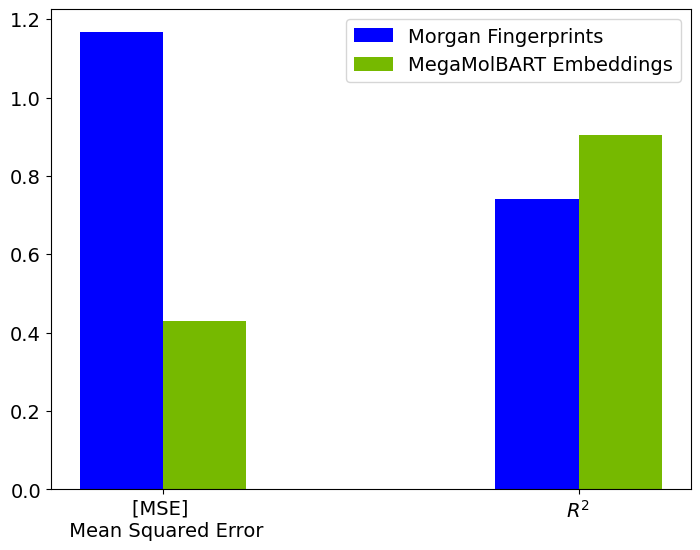

In [19]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})
data = [[cp.asnumpy(mfp_SVR_MSE), mfp_SVR_R2],
[cp.asnumpy(emb_SVR_MSE), emb_SVR_R2]]
X = np.arange(2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.20)
ax.bar(X + 0.20, data[1], color = '#76b900', width = 0.20)
ax.set_xticks([0.1, 1.1])
ax.set_xticklabels(['[MSE] \n Mean Squared Error', '$R^2$'])
ax.legend(['Morgan Fingerprints', 'MegaMolBART Embeddings'],loc='best')

<br><br>

Let's also examine the experimental and predicted ESOL values from both regressors trained on different featurizations.


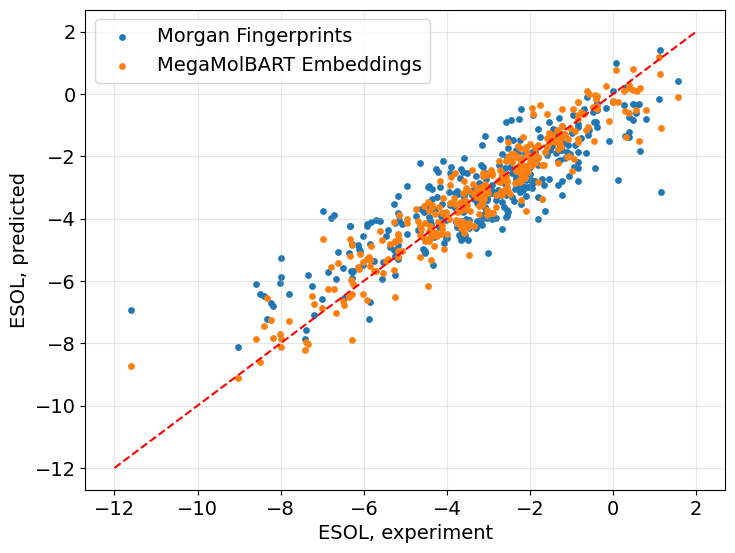

In [20]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(cp.asnumpy(y_test_mfp), cp.asnumpy(pred_mfp), s=15, label='Morgan Fingerprints')
ax.scatter(cp.asnumpy(y_test_mfp), cp.asnumpy(pred_emb), s=15, label='MegaMolBART Embeddings')
ax.grid(alpha=0.3)
ax.plot([-12, 2], [-12, 2], 'r--') # The "perfect prediction" line
ax.set_xlabel('ESOL, experiment')
ax.set_ylabel('ESOL, predicted')
ax.legend()

<br><br><br>

Predictions made with the model trained with MegaMolBART embeddings are closer to the experimental values.

__This concludes the final objective of using the embeddings for predictive modeling of downstream tasks.__


<a href='#contents'> __[Go to the top]__</a>